In [39]:
from transformers import GPT2Model, GPT2Tokenizer
import pandas as pd
import numpy as np
import torch
from vector_embedding import get_word_embeddings, calculate_similarity
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from IPython import display

In [40]:
def cosine_similarity(embeddings1, embeddings2):
    # Calculate cosine similarities for each corresponding layer's embeddings
    cosine_similarity = [1 - cosine(embedding1, embedding2) for embedding1, embedding2 in zip(embeddings1, embeddings2)]
    return cosine_similarity

In [41]:
def similarity(sentence, word1, word2, tokenizer, model, function = "cosine", layers = 8):
    embedding1, embedding2 = get_word_embeddings(sentence, word1, word2, tokenizer, model)
    return calculate_similarity(embedding1, embedding2,
        similarity_function = function,
        layers = layers)

In [42]:
# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2', output_hidden_states=True)

## Line Plot

In [43]:
df = pd.read_csv("data/4000_word_pairs.csv", index_col = "rank")
df.head()

lemma PoS     freq    synonym                      synset    random
rank                                                                    
26     say   v  4096416       tell        Synset('order.v.01')   blanket
31      go   v  3546732      start        Synset('start.v.09')     blank
34     get   v  3347615    acquire          Synset('get.v.01')  overhaul
39    know   v  2761628  recognise  Synset('acknowledge.v.06')    chisel
50    make   v  2290830        get         Synset('make.v.02')    tickle

In [44]:
PoS_map = {
    "n" : "nouns",
    "v" : "verbs",
    "a" : "adjectives",
    "r" : "adverbs"
}

In [45]:
y = []
z = []
for idx, row in df.iterrows():
    pos = PoS_map[row["PoS"]]
    word1 = row["lemma"]
    word2 = row["synonym"]
    word3 = row["random"]
    sentence = "What is the similarity between the two {0}: {1} and {2}?".format(pos, word1, word2)
    embedding1, embedding2 = get_word_embeddings(sentence, word1, word2, tokenizer, model)
    y.append(cosine_similarity(embedding1, embedding2))
    sentence = "What is the similarity between the two {0}: {1} and {2}?".format(pos, word1, word3)
    embedding1, embedding2 = get_word_embeddings(sentence, word1, word3, tokenizer, model)
    z.append(cosine_similarity(embedding1, embedding2))
    if len(y) > 10:
        break

In [46]:
fig, ax = plt.subplots(figsize=(10, 6), dpi = 1080)
x = list(range(1, 14))
for i in range(len(y)):
    ax.plot(x, y[i], linestyle='-', linewidth=2, marker = "o", alpha = 0.7, c = "#f678a7")
    ax.plot(x, z[i], linestyle='-', linewidth=2, marker = "o", alpha = 0.7, c = "#62aec5")
ax.grid(True, which='both', linestyle='--', linewidth=0.2, color='gray')
ax.axvline(x=8, color='red', linestyle=':', linewidth=1.5)

# Add labels, title, and legend
ax.set_xlabel('Layers in GPT', fontsize=14)
ax.set_ylabel('Cosine Similarity', fontsize=14)
ax.set_ylim(0.2, 1)
ax.set_title('Cosine Similarity of Vector Embeddings across GPT Layers', fontsize=16)
label_synonym = Line2D([0], [0], color='#f678a7', linewidth=2)
label_random = Line2D([0], [0], color='#62aec5', linewidth=2)
ax.legend([label_synonym, label_random],
          ['Synonym Pairs', 'Random Pairs'],loc='lower right', fontsize=12)

# Add some padding around the plot
plt.tight_layout()

# Show the plot#f678a7
plt.show()

## Histogram

In [47]:
df = pd.read_csv("data/4000_complete_data.csv")

In [48]:
fig, ax = plt.subplots(figsize=(10, 6), dpi = 1080)
ax.hist(df["synonym_similarity"], label = "Synonym Pairs", bins = 80, alpha = 0.7, color = "#f678a7")
ax.hist(df["random_similarity"], label = "Random Pairs", bins = 80, alpha = 0.7, color = "#62aec5")
ax.grid(True, which='both', linestyle='--', linewidth=0.2, color='gray')
ax.axvline(df["synonym_similarity"].mean(), color='#f678a7', linestyle=':', linewidth=1.5)
ax.axvline(df["random_similarity"].mean(), color='#62aec5', linestyle=':', linewidth=1.5)

# Add labels, title, and legend
ax.set_xlabel('GPT Similarity Scores', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlim(0.4, 1)
ax.set_title('Distribution of GPT Similarity Scores', fontsize=16)
ax.legend(loc='upper right', fontsize=12)

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

## Heatmap

In [49]:
df = pd.read_csv("data/456_complete_data.csv", index_col="Unnamed: 0")

In [50]:
scaler = MinMaxScaler()
df["human"] = scaler.fit_transform(df[["human"]])
scaler = MinMaxScaler()
df["gpt2"] = scaler.fit_transform(df[["gpt2"]])
scaler = MinMaxScaler()
df["gpt4"] = scaler.fit_transform(df[["gpt4"]])
df["lin_common"] = df["lin_common"].abs()
df["common"] = (df["wup_common"] + df["lin_common"]) / 2
df["average"] = (df["wup_average"] + df["lin_average"]) / 2

In [51]:
# df_filter = df[(df["human"] > 0.52) & (df["human"] < 0.73)]
df_filter = df[df["human"] > 0.7]
df_filter.shape

(166, 13)

In [52]:
# Calculate the correlation matrix
corr_matrix = df[["human", "gpt2", "wup_common", "wup_average", "lin_common", "lin_average", "common", "average"]].corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6), dpi = 1080)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

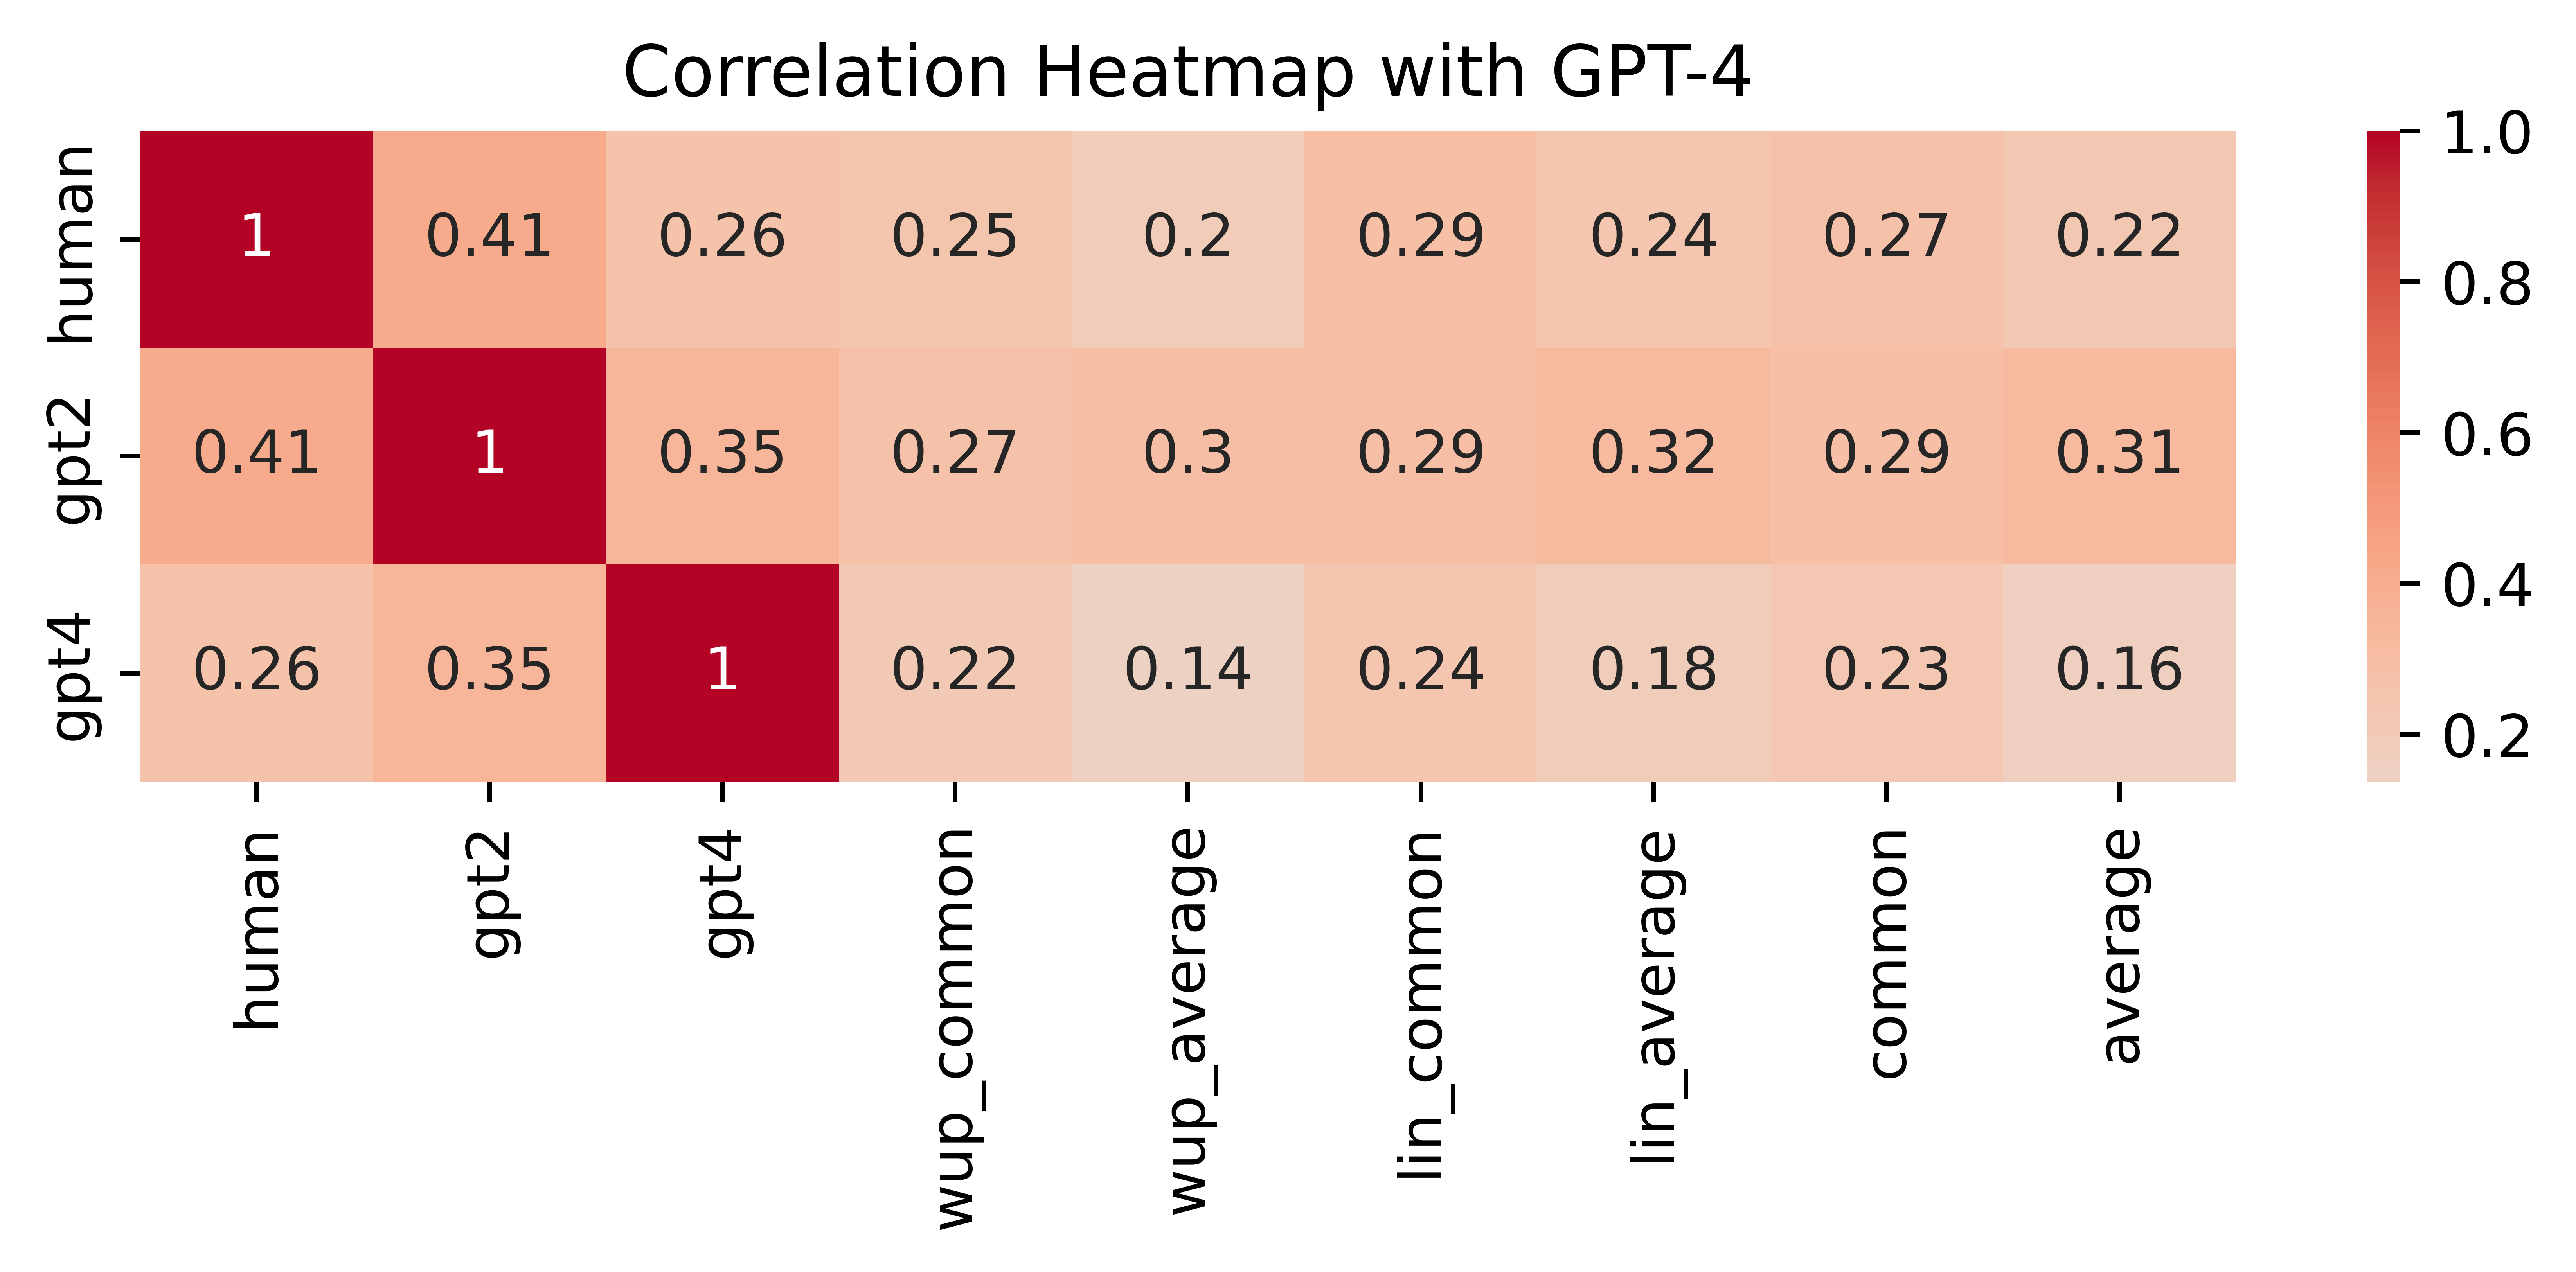

In [53]:

corr_matrix = df[["human", "gpt2", "gpt4", "wup_common", "wup_average", "lin_common", "lin_average", "common", "average"]].corr()

# Plotting the heatmap
plt.figure(figsize=(8, 2), dpi = 1080)
sns.heatmap(corr_matrix.iloc[:3, :], annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap with GPT-4')
plt.show()

## Bar Chart

In [54]:
df['human_segment'] = pd.qcut(df['human'], q=3, labels=["Low", "Medium", "High"])
correlations = []
for segment in ["Low", "Medium", "High"]:
    subset = df[df['human_segment'] == segment]
    corr_common = subset['human'].corr(subset['lin_common'])
    corr_average = subset['human'].corr(subset['lin_average'])
    correlations.append({'Segment': segment, 'Comparison': 'Lin Common', 'Correlation': corr_common})
    correlations.append({'Segment': segment, 'Comparison': 'Lin Average', 'Correlation': corr_average})

# Create a DataFrame for plotting
corr_df = pd.DataFrame(correlations)

# Create the grouped bar chart with a similar style
fig, ax = plt.subplots(figsize=(10, 6), dpi=1080)

# Barplot using seaborn
sns.barplot(x='Segment', y='Correlation', hue='Comparison', data=corr_df, ax=ax, palette=["#5F4B8B", "#E69A8D"], alpha=0.7, width = 0.7)

# Customize the grid
ax.grid(True, which='both', linestyle='--', linewidth=0.2, color='gray')

# Add labels, title, and legend
ax.set_xlabel('Human Similarity Score Segments', fontsize=14)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_ylim(-0.1, 0.35)
ax.set_title('Correlation: Human vs. Lin Similarity Scores by Segment', fontsize=16)
ax.legend(loc='upper left', fontsize=12)

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

In [55]:
df['gpt2_segment'] = pd.qcut(df['gpt2'], q=3, labels=["Low", "Medium", "High"])
correlations = []
for segment in ["Low", "Medium", "High"]:
    subset = df[df['gpt2_segment'] == segment]
    corr_common = subset['gpt2'].corr(subset['lin_common'])
    corr_average = subset['gpt2'].corr(subset['lin_average'])
    correlations.append({'Segment': segment, 'Comparison': 'Lin Common', 'Correlation': corr_common})
    correlations.append({'Segment': segment, 'Comparison': 'Lin Average', 'Correlation': corr_average})

# Create a DataFrame for plotting
corr_df = pd.DataFrame(correlations)

# Create the grouped bar chart with a similar style
fig, ax = plt.subplots(figsize=(10, 6), dpi=1080)

# Barplot using seaborn
sns.barplot(x='Segment', y='Correlation', hue='Comparison', data=corr_df, ax=ax, palette=["#5F4B8B", "#E69A8D"], alpha=0.7, width = 0.7)

# Customize the grid
ax.grid(True, which='both', linestyle='--', linewidth=0.2, color='gray')

# Add labels, title, and legend
ax.set_xlabel('GPT Similarity Score Segments', fontsize=14)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_ylim(-0.1, 0.35)
ax.set_title('Correlation: GPT vs. Lin Similarity Scores by Segment', fontsize=16)
ax.legend(loc='upper left', fontsize=12)

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()